In [3]:
# ===============================================================
# PROYEK UTS - KECERDASAN BUATAN
# Klasifikasi Ujaran Kebencian (Hate Speech Detection)
# Algoritma: Naive Bayes dengan TF-IDF
# ===============================================================

!pip install sastrawi wordcloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import warnings
warnings.filterwarnings('ignore')

# Library Preprocessing
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Library Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score, classification_report)
from imblearn.under_sampling import RandomUnderSampler

# Set style untuk visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.6 MB/s eta 0:00:00


Silakan upload file: IDHSD_RIO_unbalanced_713_2017.csv


Saving IDHSD_RIO_unbalanced_713_2017.csv to IDHSD_RIO_unbalanced_713_2017.csv

📊 Total data: 713 tweets

🔍 5 Data Pertama:
    Label                                              Tweet
0  Non_HS  RT @spardaxyz: Fadli Zon Minta Mendagri Segera...
1  Non_HS  RT @baguscondromowo: Mereka terus melukai aksi...
2  Non_HS  Sylvi: bagaimana gurbernur melakukan kekerasan...
3  Non_HS  Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...
4  Non_HS  RT @lisdaulay28: Waspada KTP palsu.....kawal P...

📈 Distribusi Label:
Label
Non_HS    453
HS        260
Name: count, dtype: int64

Persentase:
Label
Non_HS    63.534362
HS        36.465638
Name: proportion, dtype: float64


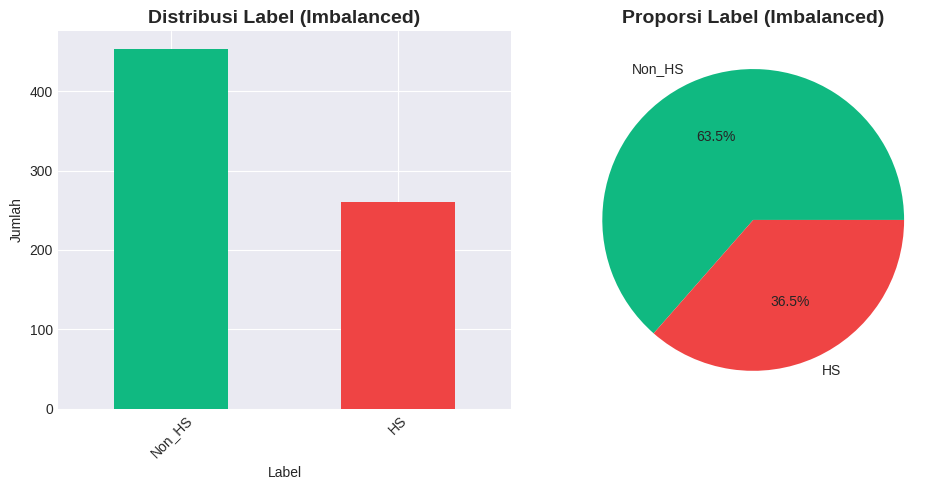

In [4]:
# ===============================================================
# LANGKAH 1: Load Dataset
# ===============================================================


# Upload file CSV (jika di Google Colab)
from google.colab import files
print("Silakan upload file: IDHSD_RIO_unbalanced_713_2017.csv")
uploaded = files.upload()

# Load dataset
df = pd.read_csv('IDHSD_RIO_unbalanced_713_2017.csv')

print(f"\n📊 Total data: {len(df)} tweets")
print(f"\n🔍 5 Data Pertama:")
print(df.head())

print(f"\n📈 Distribusi Label:")
print(df['Label'].value_counts())
print(f"\nPersentase:")
print(df['Label'].value_counts(normalize=True) * 100)

# Visualisasi distribusi label ASLI (Imbalanced)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
df['Label'].value_counts().plot(kind='bar', color=['#10b981', '#ef4444'])
plt.title('Distribusi Label (Imbalanced)', fontsize=14, fontweight='bold')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
df['Label'].value_counts().plot(kind='pie', autopct='%1.1f%%',
                                 colors=['#10b981', '#ef4444'])
plt.title('Proporsi Label (Imbalanced)', fontsize=14, fontweight='bold')
plt.ylabel('')

plt.tight_layout()
plt.show()

In [5]:
# ===============================================================
# LANGKAH 2: PREPROCESSING TEKS
# ===============================================================

# Inisialisasi Stemmer dan Stopword Remover
factory_stemmer = StemmerFactory()
stemmer = factory_stemmer.create_stemmer()

factory_stopword = StopWordRemoverFactory()
stopword_remover = factory_stopword.create_stop_word_remover()

def preprocessing(text):
    # 1. Case folding
    text = text.lower()

    # 2. Menghapus URL, mention, hashtag, RT
    text = re.sub(r'http\S+', '', text)  # URL
    text = re.sub(r'@\w+', '', text)      # Mention
    text = re.sub(r'#\w+', '', text)      # Hashtag
    text = re.sub(r'\brt\b', '', text)    # RT

    # 3. Menghapus angka dan tanda baca
    text = re.sub(r'\d+', '', text)       # Angka
    text = re.sub(r'[^\w\s]', ' ', text)  # Tanda baca

    # 4. Menghapus whitespace berlebih
    text = re.sub(r'\s+', ' ', text).strip()

    # 5. Stopword removal
    text = stopword_remover.remove(text)

    # 6. Stemming
    text = stemmer.stem(text)

    return text

# Apply preprocessing
print("⏳ Memproses preprocessing...")
df['clean_text'] = df['Tweet'].apply(preprocessing)

print(f"\n✅ Preprocessing selesai!")
print("\n📝 Contoh hasil preprocessing:")
for i in range(3):
    print(f"\nOriginal: {df['Tweet'].iloc[i][:100]}...")
    print(f"Cleaned:  {df['clean_text'].iloc[i][:100]}...")

# Hapus tweet yang kosong setelah preprocessing
df = df[df['clean_text'].str.strip() != '']
print(f"\n📊 Total data setelah cleaning: {len(df)} tweets")

⏳ Memproses preprocessing...

✅ Preprocessing selesai!

📝 Contoh hasil preprocessing:

Original: RT @spardaxyz: Fadli Zon Minta Mendagri Segera Menonaktifkan Ahok Jadi Gubernur DKI https:\/\/t.co\/...
Cleaned:  fadli zon minta mendagri segera nonaktif ahok jadi gubernur dki...

Original: RT @baguscondromowo: Mereka terus melukai aksi dalam rangka memenjarakan Ahok atau Ahok gagal dalam ...
Cleaned:  terus luka aksi rangka penjara ahok ahok gagal pilkada...

Original: Sylvi: bagaimana gurbernur melakukan kekerasan perempuan? Buktinya banyak ibu2 mau foto bareng #Deba...
Cleaned:  sylvi bagaimana gurbernur laku keras perempuan bukti banyak ibu mau foto bareng...

📊 Total data setelah cleaning: 713 tweets


⚠️  Dataset tidak seimbang!
Non_HS: 453 (63.53%)
HS: 260 (36.47%)

✅ Balancing selesai!
Total data setelah under-sampling: 520 tweets
Non_HS: 260 (50%)
HS: 260 (50%)


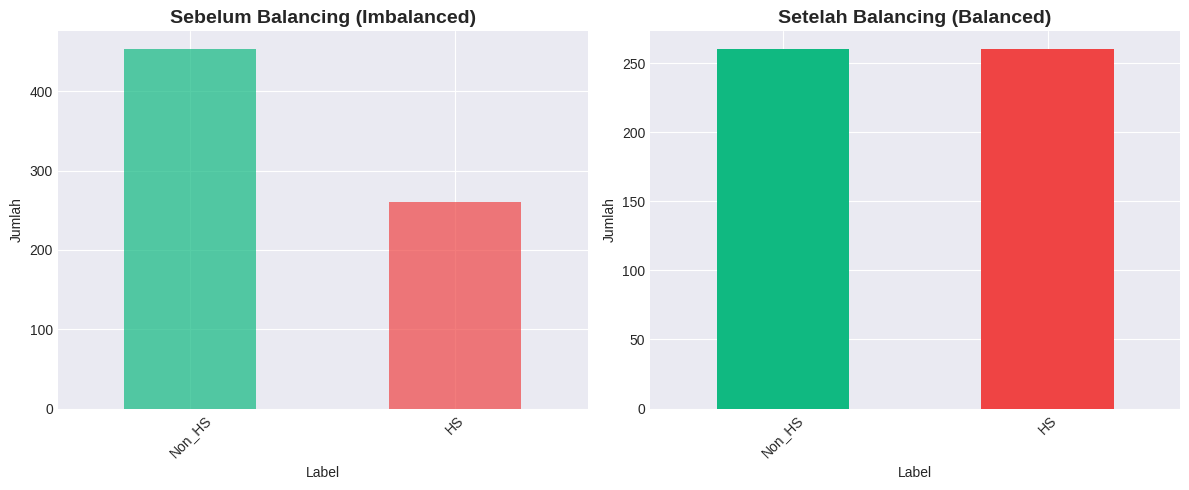

In [6]:
# ===============================================================
# LANGKAH 3: BALANCING DATA (Under-Sampling)
# ===============================================================

print("⚠️  Dataset tidak seimbang!")
print(f"Non_HS: {len(df[df['Label']=='Non_HS'])} ({len(df[df['Label']=='Non_HS'])/len(df)*100:.2f}%)")
print(f"HS: {len(df[df['Label']=='HS'])} ({len(df[df['Label']=='HS'])/len(df)*100:.2f}%)")

# Konversi label ke numerik
df['label_num'] = df['Label'].map({'Non_HS': 0, 'HS': 1})

# Under-sampling
X = df[['clean_text']]
y = df['label_num']

undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Buat dataframe baru yang sudah balanced
df_balanced = pd.DataFrame({
    'clean_text': X_resampled['clean_text'].values,
    'label_num': y_resampled,
    'Label': ['Non_HS' if l == 0 else 'HS' for l in y_resampled]
})

print(f"\n✅ Balancing selesai!")
print(f"Total data setelah under-sampling: {len(df_balanced)} tweets")
print(f"Non_HS: {len(df_balanced[df_balanced['Label']=='Non_HS'])} (50%)")
print(f"HS: {len(df_balanced[df_balanced['Label']=='HS'])} (50%)")

# Visualisasi setelah balancing
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df['Label'].value_counts().plot(kind='bar', color=['#10b981', '#ef4444'], alpha=0.7)
plt.title('Sebelum Balancing (Imbalanced)', fontsize=14, fontweight='bold')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
df_balanced['Label'].value_counts().plot(kind='bar', color=['#10b981', '#ef4444'])
plt.title('Setelah Balancing (Balanced)', fontsize=14, fontweight='bold')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [7]:
# ===============================================================
# LANGKAH 4: REPRESENTASI FITUR (TF-IDF)
# ===============================================================

# Split data menjadi train dan test
X = df_balanced['clean_text']
y = df_balanced['label_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📊 Pembagian Data:")
print(f"Training: {len(X_train)} samples")
print(f"Testing: {len(X_test)} samples")

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"\n✅ TF-IDF selesai!")
print(f"Jumlah fitur: {X_train_tfidf.shape[1]}")
print(f"Dimensi X_train: {X_train_tfidf.shape}")
print(f"Dimensi X_test: {X_test_tfidf.shape}")

📊 Pembagian Data:
Training: 416 samples
Testing: 104 samples

✅ TF-IDF selesai!
Jumlah fitur: 1000
Dimensi X_train: (416, 1000)
Dimensi X_test: (104, 1000)


In [8]:
# ===============================================================
# LANGKAH 5: PEMBANGUNAN MODEL (NAIVE BAYES)
# ===============================================================

# Training model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

print("✅ Model Naive Bayes berhasil ditraining!")

# Prediksi
y_pred = nb_model.predict(X_test_tfidf)

✅ Model Naive Bayes berhasil ditraining!



📋 Classification Report:
              precision    recall  f1-score   support

      Non_HS       0.92      0.87      0.89        52
          HS       0.87      0.92      0.90        52

    accuracy                           0.89       104
   macro avg       0.90      0.89      0.89       104
weighted avg       0.90      0.89      0.89       104



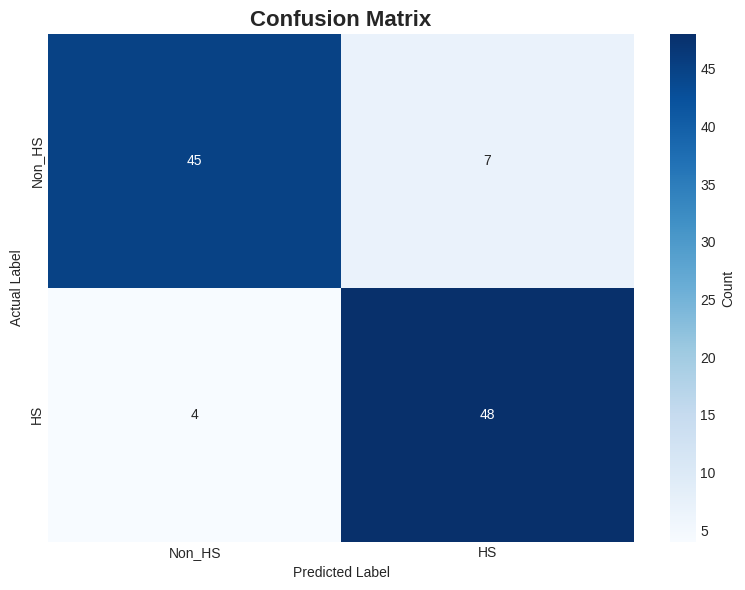

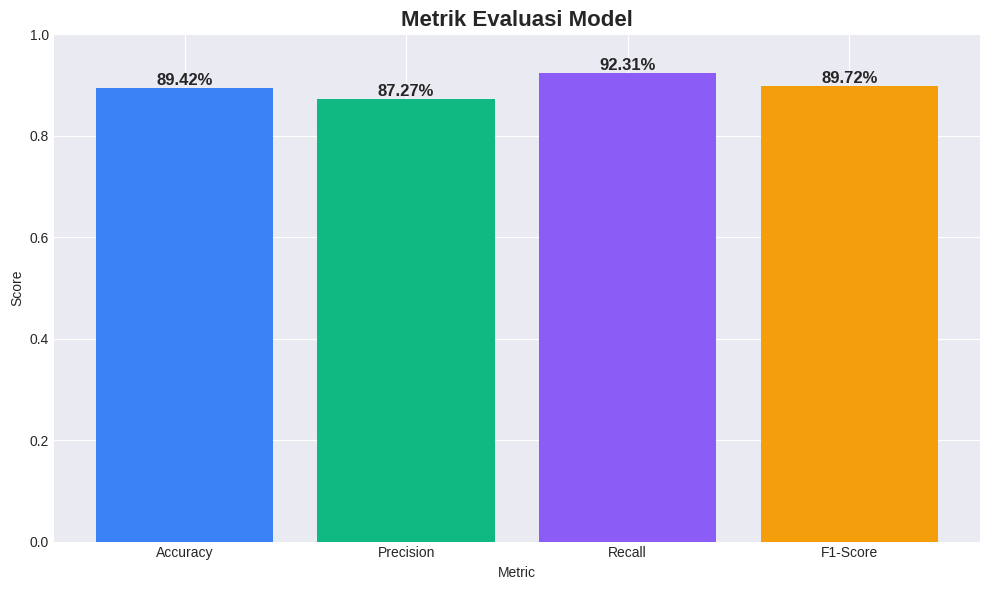

In [12]:
# ===============================================================
# LANGKAH 6: EVALUASI MODEL
# ===============================================================

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()


# Metrik Evaluasi
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non_HS', 'HS']))

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non_HS', 'HS'],
            yticklabels=['Non_HS', 'HS'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Visualisasi Metrik Evaluasi
metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Score': [accuracy, precision, recall, f1]
}
metrics_df = pd.DataFrame(metrics_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_df['Metric'], metrics_df['Score'],
               color=['#3b82f6', '#10b981', '#8b5cf6', '#f59e0b'])
plt.ylim(0, 1)
plt.title('Metrik Evaluasi Model', fontsize=16, fontweight='bold')
plt.ylabel('Score')
plt.xlabel('Metric')

# Tambahkan nilai di atas bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2%}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

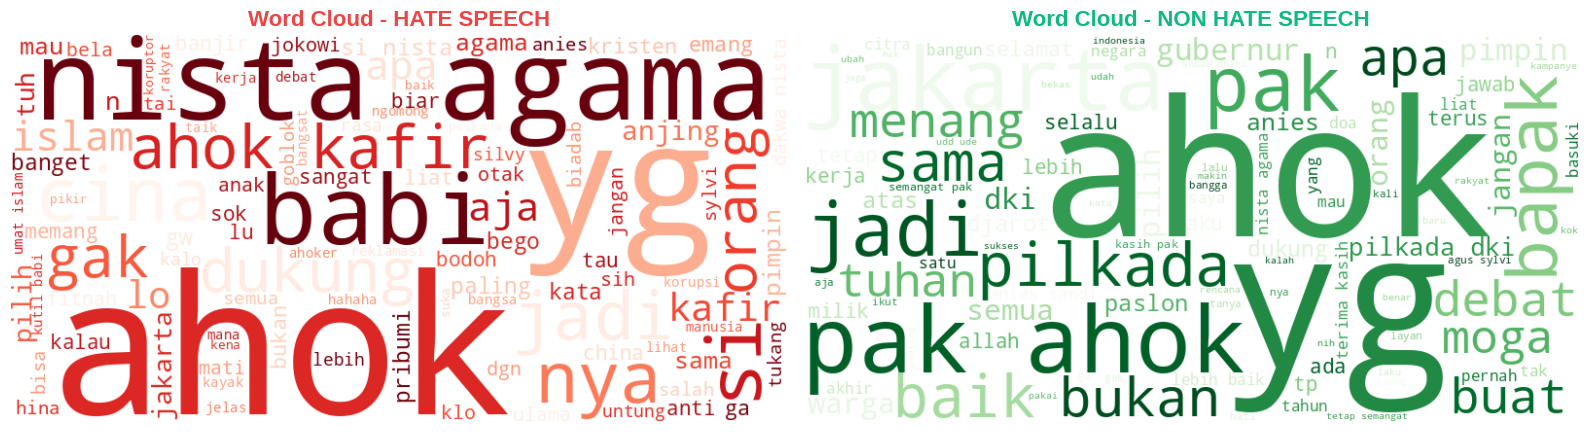

In [13]:
# ===============================================================
# LANGKAH 7: VISUALISASI WORD CLOUD
# ===============================================================

# Gabungkan semua teks Hate Speech
hate_speech_text = ' '.join(df_balanced[df_balanced['Label']=='HS']['clean_text'])
non_hate_speech_text = ' '.join(df_balanced[df_balanced['Label']=='Non_HS']['clean_text'])

# Generate Word Cloud untuk Hate Speech
plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
wordcloud_hs = WordCloud(width=800, height=400,
                          background_color='white',
                          colormap='Reds',
                          max_words=100,
                          relative_scaling=0.5).generate(hate_speech_text)
plt.imshow(wordcloud_hs, interpolation='bilinear')
plt.title('Word Cloud - HATE SPEECH', fontsize=16, fontweight='bold', color='#ef4444')
plt.axis('off')

plt.subplot(1, 2, 2)
wordcloud_non = WordCloud(width=800, height=400,
                           background_color='white',
                           colormap='Greens',
                           max_words=100,
                           relative_scaling=0.5).generate(non_hate_speech_text)
plt.imshow(wordcloud_non, interpolation='bilinear')
plt.title('Word Cloud - NON HATE SPEECH', fontsize=16, fontweight='bold', color='#10b981')
plt.axis('off')

plt.tight_layout()
plt.show()